# Learning representations in hierarchical generative deep learning models: an overview of a simple DBN

## Introduction

 **Neurons** in the brain communicate via electrical signals in the voltage of the membrane. The interneuron connections are mediated by electrochemical junctions, called synapses, which are located on branches of the cell referred to as dendrites. Each neuron typically receives many thousands of connections from other neurons and is thus constantly receiving many incoming signals. In determining whether an impulse should be produced or not, some incoming signals generate an inhibitory effect and tend to prevent the "excitation", while others are excitatory and promote the impulse generation. (Gurney, 2018)

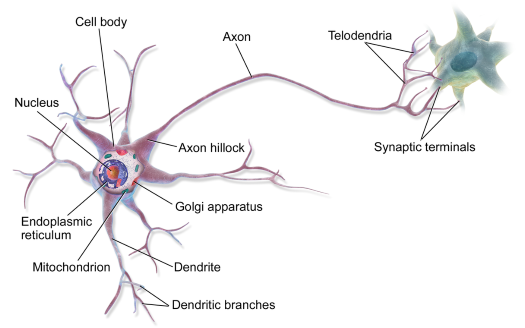

Biological neuron diagram. https://en.wikipedia.org/wiki/Neuron

**Artificial Neural Networks** (ANN) were originally inspired by the processing and output of **biological neurons**. The artificial equivalent of biological neurons are the nodes or "neurons" that are the core component of ANN's. Synapses are modelled by a numerical value called "weight" so that each input is multiplied by it before being sent to the receiving node. The weight signals of the nodes are summed together and by the use of an activation function, the excitation of that node is determined. (Gurney, 2018)

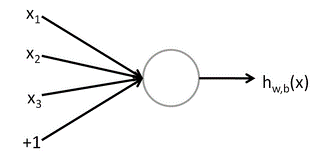

A very simple ANN with inputs X. (Bond-Taylor, 2018)

**Deep learning** refers to the fact that circuits are typically organized into many layers, which means that the computation paths from inputs to outputs have many steps.
The core idea behind deep learning is to train circuits such that the computational paths are long, allowing for the input variables to interact in complex ways. (Russel & Norvig, 2022)

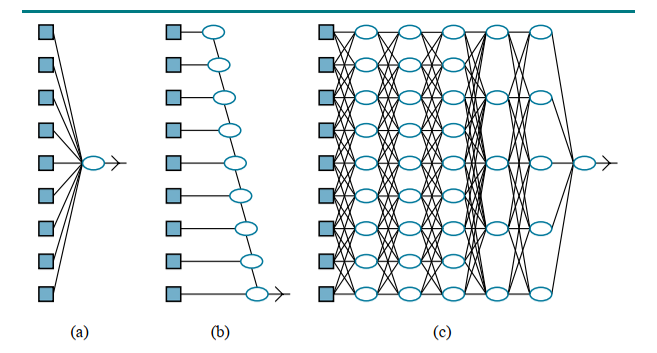

Comparison between a) A shallow model such as linear regression, which has short computational paths between inputs and outputs. b) A decision list network has some long paths for some possible input values, but most paths are short. c) A deep learning network has longer computational paths, allowing each variable to interact with all the others.  (Russel & Norvig, 2022) 


**Restricted Boltzmann Machines** (RBMs) are undirected probabilistic graphical models containing a layer of observable variables and a single layer of latent variables, they are called restricted as there are no connections between nodes of a layer.

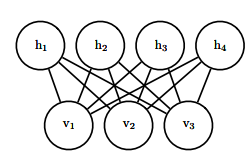

A simple RBM (Goodfellow et al., 2017)

The Restricted Boltzmann machine is an energy based model with the joint probability distribution specified by the energy function:

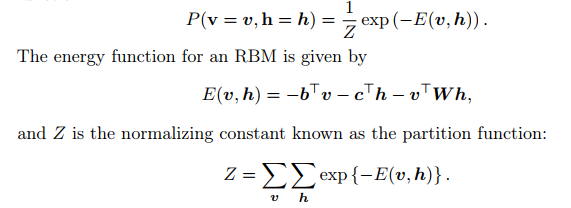

(Goodfellow et al., 2017). 


The bipartite graph structure of the RBM has the special property of its conditional distributions P(h | v) and P(v | h) being factorial and relatively simple to compute and sample from.

RBMs are relatively straightforward to train because we can compute  P(h | v) exactly in closed form. 


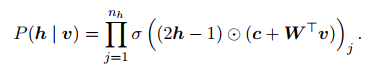

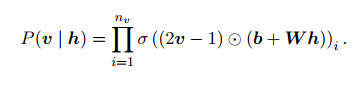

(Goodfellow et al., 2017)

**Deep Belief Networks (DBNs)** are hierarchical generative models with several layers of latent variables. The latent variables are typically binary while the visible units, which are located the input to out ANN, may be binary or real. DBNs have no intralayer connections, the connections between the top two layers are undirected. (Goodfellow et al., 2017). 
A hierarchical model is a model in which lower levels are sorted under a hierarchy of successively higher-level units, inferences which are made about one quantity affect inference about another. Deep generative models are a class of techniques that train deep neural networks to model the distribution of training samples. (Bond-Taylor, 2018)
A DBN can be constructed by stacking RBMs, having the great advantage that the model can be trained via unsupervised learning, i.e. the input data to the model does not need to be previously classified in order for the distribution to be learned.
A classifier model can be trained via supervised learning on top of the final layer of the stacked RBMs to obtain a final labelling output for the model. A benefit of having a previously learned distribution is that the final classification algorithm can be trained through few examples. Few shot learning is explored in the model implementation.

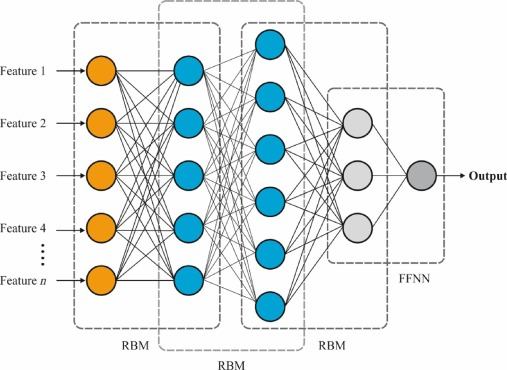

DBN with a readout classifier. https://ars.els-cdn.com/content/image/3-s2.0-B9780323858540000101-f09-02-9780323858540.jpg

DBNs are good candiates for visual processing as: "[...] the processing of complex visual information requires hierarchical organization where neurons in the early levels extract simple features over local regions of the visual field that are successively combined into more complex features covering larger portions of the visual scene. 
Visual processing can be conceived as a series of non-linear transformations over the sensory input to build more abstract, internal representations that are invariant to irrelevant changes in visual appearance" (Testolin et al., 2017)

## Implementation of a DBN using the FashionMNIST dataset

A DBN will be implemented using the Fashion-MNIST dataset. 

For the implementation, code from flavio.petruzzellis@phd.unipd.it was used.

In [1]:
# We get the DBN and RBM scripts from Flavio's directory
def _get_files_from_repo(files, repo):
  repository_url = f"https://raw.githubusercontent.com/flavio2018/{repo}/master/" 
  # url for the files that we need
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
# Get the files that we need
%%capture
files = ["DBN.py", "RBM.py"]
_get_files_from_repo(files, "Deep-Belief-Network-pytorch")

In [3]:
# Imort libraries that we will use
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torchvision as tv
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

from DBN import DBN

### Dataset
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
Fashion-MNIST is considered a more complex version of the very popular MNIST data set which consists of handwritten digits fromo 0 to 9.

https://github.com/zalandoresearch/fashion-mnist

In [4]:
# Select our computational device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
%%capture
# Our training dataset
mnist_train = tv.datasets.FashionMNIST('data/',
                                 train=True,
                                 download=True,
                                 transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

# Test dataset
mnist_test = tv.datasets.FashionMNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [6]:
# we divide between 255 as we want to normalize the grayscale values between 0 and 1
mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

In [7]:
# Our mnsit_train.data are torch.Tensor objects, we assign them to our CUDA device
# if available
mnist_train.data = mnist_train.data.to(device)
mnist_test.data = mnist_test.data.to(device)
mnist_train.targets = mnist_train.targets.to(device)
mnist_test.targets = mnist_test.targets.to(device)

In [8]:
# Explore our dataset a little
print(f'The shape of our training dataset is: {mnist_train.data.shape}')
print(f'The shape of our test dataset is: {mnist_test.data.shape}')
print(f'The number of distinct labels that we have is: {len(torch.unique(mnist_train.targets))}')

The shape of our training dataset is: torch.Size([60000, 28, 28])
The shape of our test dataset is: torch.Size([10000, 28, 28])
The number of distinct labels that we have is: 10


In [9]:
# Create a dict that maps label numbers to type of clothing
labels = {0:'T-shirt/top',
          1:'Trouser',
          2:'Pullover',
          3:'Dress',
          4:'Coat',
          5:'Sandal',
          6:'Shirt',
          7:'Sneaker',
          8:'Bag',
          9:'Ankle boot'}

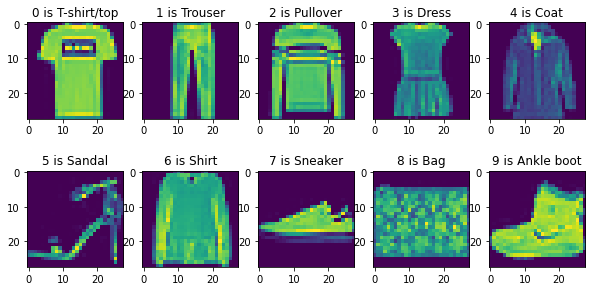

In [10]:
# setting values to rows and column variables
def plot_labels():
  rows = 2
  columns = 5
  fig = plt.figure(figsize=(10, 5))
  for i in range(0, 10):
    idx = int(torch.where(mnist_train.targets==i)[0].cpu()[0])
    img = mnist_train.data[idx].cpu()
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i + 1)
    # showing image
    plt.imshow(img)
    plt.title(f'{i} is {labels[i]}')
plot_labels()

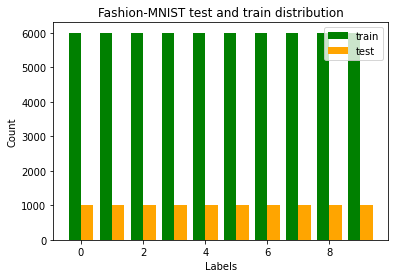

In [11]:
# Get the distribution for our training data set
# data to be plotted
x1 = [i for i in range(0, 10)] 
y1 = torch.bincount(mnist_train.targets.cpu())
x2 = x1
y2 = torch.bincount(mnist_test.targets.cpu())
X_axis = np.arange(len(x1))
# plotting
plt.title("Fashion-MNIST test and train distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.bar(X_axis - .2, y1, color ='green', width = 0.4, label = 'train')
plt.bar(X_axis + .2, y2, color ='orange', width = 0.4, label ='test')
plt.legend()
plt.show()

### DBN


For the DBN a 784-500-500-1000-c structure will be used. i.e. 784 (28 x 28 pixels) data-points are input in the visible layer followed by 3 hidden layers, the first two with 500 nodes and the third one by 1000. Finally a linear classifier ouputs the prediction.

An additional 784-500-c one hidden layer network is also trained to compare our DBN with a similar architecture model but much simpler structure.

In [12]:
# We define the architecure of our DBN layers
n1 = 500
n2 = 500
n3 = 1000
dbnl1 = [n1, n2, n3]

In [13]:
# we are defining our model
dbn_mnist = DBN(visible_units=28*28, # visible input to our DBN
                hidden_units=dbnl1, # structure previously defined
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [14]:
# One 500 nodes hidden layer network for comparison purposes
dbn_mnist_1layer = DBN(visible_units=28*28, #visible input to our DBN
                hidden_units=[500], #we define the number of hidden layers with, changed to 400>40, 500>50, 800>80
                # the number of neuron that we want
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [15]:
# we define the number of EPOCHS and the mini-batch size for training
num_epochs = 50
batch_size = 128

In [16]:
# we give the function the parameters including the data and labels (targets)
# from our training dataset (mnist_train.data and mnist_train.labels)
dbn_mnist.train_static(
    mnist_train.data,
    mnist_train.targets,
    num_epochs,
    batch_size
)


--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.9139     |0.0817       |323.5827   |8.5220     |
|20    |1.7272     |0.0749       |288.6776   |5.8236     |
|30    |1.6764     |0.0738       |282.5489   |5.6832     |
|40    |1.6494     |0.0735       |277.3865   |5.3622     |
|50    |1.6363     |0.0707       |276.2354   |5.4741     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1747     |0.0366       |158.1303   |3.3316     |
|20    |1.0512     |0.0325       |147.8506   |2.7223     |
|30    |1.0221     |0.0287       |145.7357   |2.7806     |
|40    |1.0062     |0.0306       |143.3460   |2.9643     |
|50    |0.9977     |0.0288       |142.5789   |2.5767     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0291     |0.0331       |149.1179   |3.4379     |
|20    |0.9089     |0.0300       |134.8882   |2.656

In [17]:
# Training of the one layer DBN
dbn_mnist_1layer.train_static(
    mnist_train.data,
    mnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8876     |0.0821       |310.5234   |7.5606     |
|20    |1.7096     |0.0755       |280.8200   |6.4124     |
|30    |1.6647     |0.0745       |274.1760   |5.4925     |
|40    |1.6419     |0.0723       |270.3038   |5.0971     |
|50    |1.6315     |0.0703       |271.0761   |5.0387     |


## Visual processing throughout the hierarchy of the model

Hierarchical, multilayer processing seems to be well suited for learning distinct image representations throughout the models layers. Learning these representations is similar to what occurs in the brain, as shown by neuroimaging evidence which suggests that partial areas from a letter can be recognized by humans. (Testolin et al., 2017)
By observing different visual representations of the images that are generated at each layer, it is possible to gain insight into the functioning of complex models such as a DBN. 

In [18]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold) #make the picture look better
  
def plot_layer_receptive_fields(weights): #plot the receptive fields
  num_subplots = 100 # number of receptive fields we want to plot
  n_rows_cols = int(math.sqrt(num_subplots)) 
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(14, 14))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)))  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

In [19]:
learned_weights_layer_1layer = get_weights(dbn_mnist_1layer, layer=0)
learned_weights_layer_1layer = apply_threshold(learned_weights_layer_1layer, .1)
learned_weights_layer_1layer = apply_min_max_scaler(learned_weights_layer_1layer)

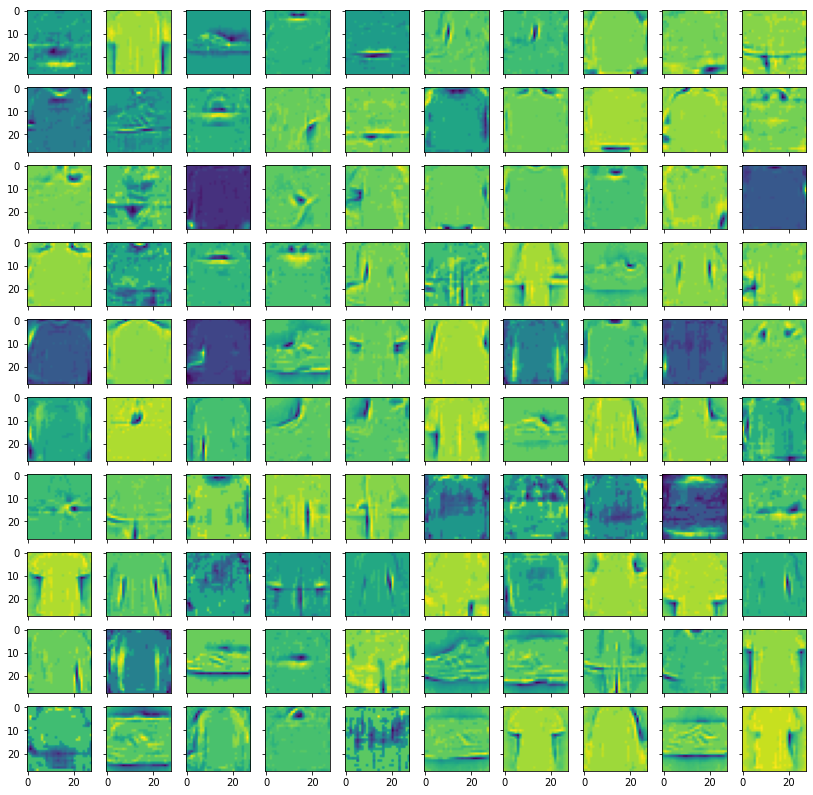

In [20]:
# Plot the receptive fields for the "one layer DBN"
plot_layer_receptive_fields(learned_weights_layer_1layer.T)

In [21]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

Receptive fields of the first hidden layer of our DBN:

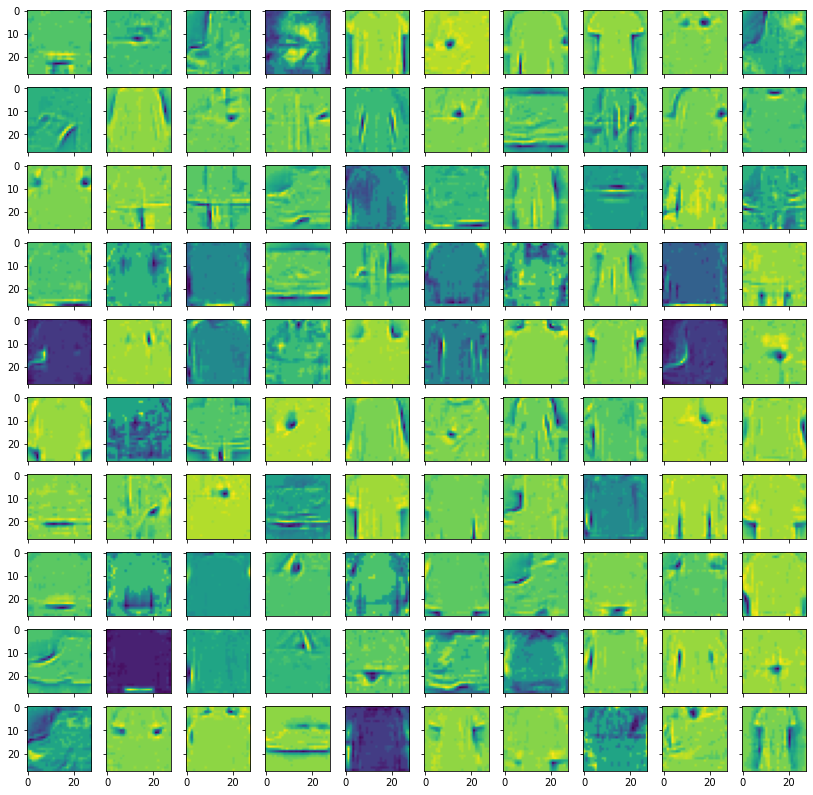

In [22]:
plot_layer_receptive_fields(learned_weights_layer_1.T)

In [23]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

Receptive fields of the second hidden layer:

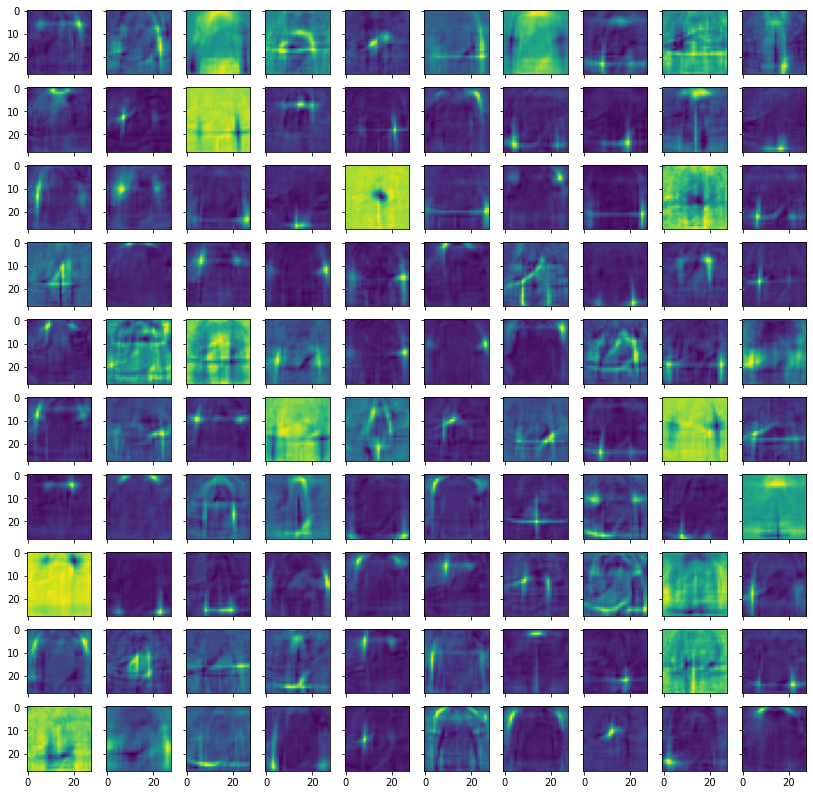

In [24]:
# Plot the receptive fields of the second layer
plot_layer_receptive_fields(learned_weights_product.T)

In [25]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_mnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

Receptive fields at the deepest representation, the third hidden layer:

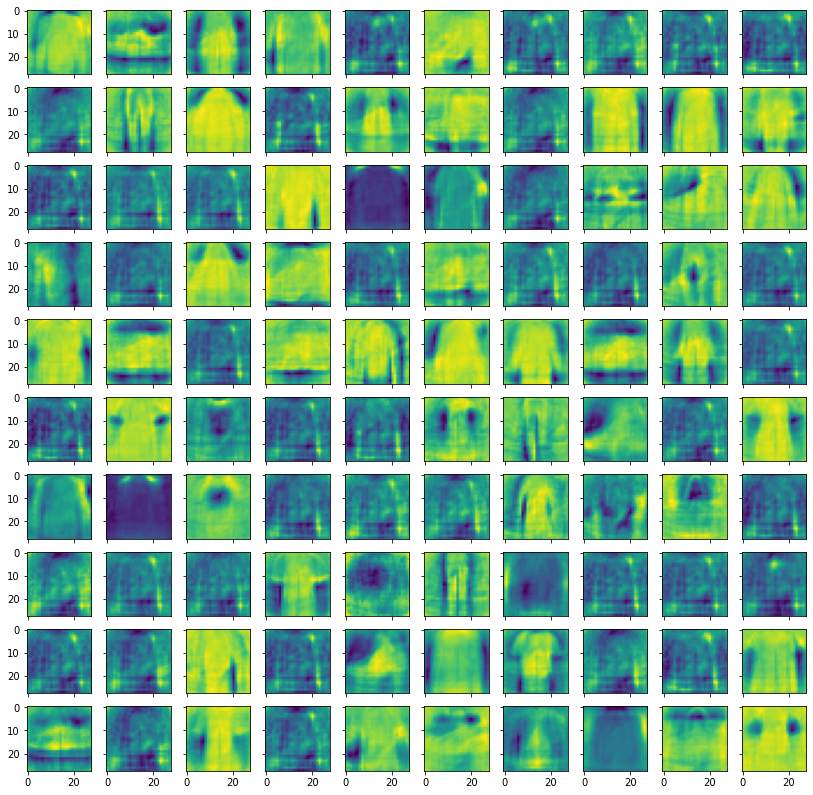

In [26]:
plot_layer_receptive_fields(learned_weights_23_product.T)

It can be seen that at the first hidden ayer of  the model has learned a mixture of features that appear to be edges as well as some that more closely resemble clothing articles from the data set. At the deeper layers of the model, multiple different articles of clothing are clearly represented.It can be seen that at the first hidden layer of  the model it has learned a mixture of features that appear to be edges as well as some that more closely resemble clothing articles from the data set. At the deeper layers of the model, multiple different articles of clothing are clearly represented.


## Linear read-outs

As we have seen in the previous section, at different depths of our model the representations learned appear to be more complex and similar to our input data.
Linear read-outs are performed at each hidden layer of our model hierarchy to explore how the sensory representations evolve as the layers go deeper. In a hirearchical model the succesive layer is influenced by the prior. For the linear read-outs, supervised learning is done with Linear Models on top of each layer of our DBN in order to get the final output accuracy for each hidden layer.




In [27]:
def get_kth_layer_repr(input, k, device): #get hidden layer activations
#what we are doing is inputting an image and storing the hidden representation we obtain (activations)
# DBN image
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [28]:
hidden_repr_layer_1 = get_kth_layer_repr(mnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [29]:
def get_kth_layer_repr_1layer(input, k, device): #get hidden layer activations
#what we are doing is inputting an image and storing the hidden representation we obtain (activations)
# DBN image
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist_1layer.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [30]:
hidden_repr_1layer = get_kth_layer_repr_1layer(mnist_train.data, 0, device)

In [31]:
class LinearModel(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [32]:
layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [33]:
layer_size_1layer = dbn_mnist_1layer.rbm_layers[0].W.shape[1]
linear_1layer = LinearModel(layer_size_1layer).to(device)

In [34]:
def train(network, input, epochs=1000):
  print_stride = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  targets = mnist_train.targets

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % print_stride == 0:
      print("epoch: {:4d}/{} | loss: {:.3f}".format(epoch, epochs, loss))
  print()

In [35]:
hidden_repr_layer_1.shape

torch.Size([60000, 500])

In [36]:
hidden_repr_layer_3.shape

torch.Size([60000, 1000])

In [37]:
train(linear1, hidden_repr_layer_1, epochs=1500)
train(linear2, hidden_repr_layer_2, epochs=1500)
train(linear3, hidden_repr_layer_3, epochs=1500)

epoch:    0/1500 | loss: 2.324
epoch:  100/1500 | loss: 0.828
epoch:  200/1500 | loss: 0.674
epoch:  300/1500 | loss: 0.608
epoch:  400/1500 | loss: 0.569
epoch:  500/1500 | loss: 0.541
epoch:  600/1500 | loss: 0.521
epoch:  700/1500 | loss: 0.505
epoch:  800/1500 | loss: 0.491
epoch:  900/1500 | loss: 0.480
epoch: 1000/1500 | loss: 0.471
epoch: 1100/1500 | loss: 0.463
epoch: 1200/1500 | loss: 0.455
epoch: 1300/1500 | loss: 0.449
epoch: 1400/1500 | loss: 0.443

epoch:    0/1500 | loss: 2.320
epoch:  100/1500 | loss: 0.752
epoch:  200/1500 | loss: 0.631
epoch:  300/1500 | loss: 0.577
epoch:  400/1500 | loss: 0.544
epoch:  500/1500 | loss: 0.521
epoch:  600/1500 | loss: 0.504
epoch:  700/1500 | loss: 0.490
epoch:  800/1500 | loss: 0.479
epoch:  900/1500 | loss: 0.470
epoch: 1000/1500 | loss: 0.462
epoch: 1100/1500 | loss: 0.455
epoch: 1200/1500 | loss: 0.449
epoch: 1300/1500 | loss: 0.444
epoch: 1400/1500 | loss: 0.440

epoch:    0/1500 | loss: 2.366
epoch:  100/1500 | loss: 0.778
epoch:

In [38]:
# Training of the one layer network
train(linear_1layer, hidden_repr_1layer, epochs=1500)

epoch:    0/1500 | loss: 2.312
epoch:  100/1500 | loss: 0.826
epoch:  200/1500 | loss: 0.672
epoch:  300/1500 | loss: 0.607
epoch:  400/1500 | loss: 0.567
epoch:  500/1500 | loss: 0.540
epoch:  600/1500 | loss: 0.520
epoch:  700/1500 | loss: 0.504
epoch:  800/1500 | loss: 0.491
epoch:  900/1500 | loss: 0.480
epoch: 1000/1500 | loss: 0.470
epoch: 1100/1500 | loss: 0.462
epoch: 1200/1500 | loss: 0.455
epoch: 1300/1500 | loss: 0.449
epoch: 1400/1500 | loss: 0.443



We build the representation from the test set and use this representation to evaluate the trained linear readouts.

In [39]:
hidden_repr_layer_1_test = get_kth_layer_repr(mnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [40]:
hidden_repr_1layer= get_kth_layer_repr_1layer(mnist_test.data, 0, device)

In [41]:
# compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [42]:
# predictions of the "one hidden layer DBN"
predictions_test_1layer= linear_1layer(hidden_repr_1layer)

In [43]:
# Computing the accuracy scores
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

Accuracy of the first hidden layer:

In [44]:
compute_accuracy(predictions_test1, mnist_test.targets)

0.8387999534606934

Accuracy of the second hidden layer:

In [45]:
compute_accuracy(predictions_test2, mnist_test.targets)

0.8363999724388123

Accuracy of the third hidden layer:

In [46]:
compute_accuracy(predictions_test3, mnist_test.targets)

0.8362999558448792

Accuracy of the "one hidden layer network":

In [47]:
compute_accuracy(predictions_test_1layer, mnist_test.targets)

0.839199960231781

The accuracy of the model improves from the first hidden layer to the second layer, meaning that our model is indeed learning more features, it then slightly decreases from the second to the third layer, which in turn may be a sign that it could be possible to decrease the number of nodes and get similar results. The accuracy of the simple, one hidden layer network, is slightly above that of the third hidden layer. We will further explore how a model with a simpler structure performs compared to the more complex DBN.

## Comparison with a Feed Forward NN

Deep feedforward networks, also known as feedforward neural networks, or multilayer perceptrons (MLPs) are one of the most relevant deep learning models. The goal of the feedforward network is to approximate some function $f$ so that learning the parameters  $\theta$ result in the best function approximation. They are called feedforward because the information flows through the function being evaluated from $x$, through the intermediate computations used to define $f$, and finally the output $y$. There are no feedback connections in which outputs of the model are fed back to itself. (Goodfellow et al., 2017)

Due to the FFNN serving as a building block in deep learning, it is relevant to use it as a comparison baseline for the performance of the DBN.

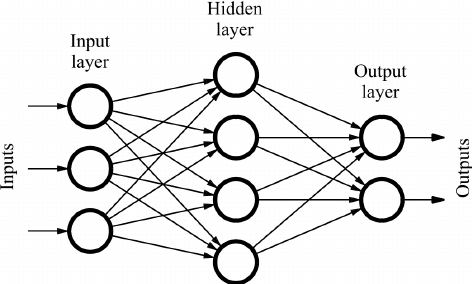

Simple feedforward network. https://deepai.org/machine-learning-glossary-and-terms/feed-forward-neural-network

In [48]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

The FFNN will have a similar structure as the DBN: 784-500-500-1000

In [49]:
ffnn = Feedforward(n1, n2, n3).to(device)

In [50]:
train(ffnn, mnist_train.data.reshape((60000, 784)), epochs=1500)

epoch:    0/1500 | loss: 2.305
epoch:  100/1500 | loss: 1.428
epoch:  200/1500 | loss: 0.906
epoch:  300/1500 | loss: 0.758
epoch:  400/1500 | loss: 0.674
epoch:  500/1500 | loss: 0.626
epoch:  600/1500 | loss: 0.579
epoch:  700/1500 | loss: 0.543
epoch:  800/1500 | loss: 0.518
epoch:  900/1500 | loss: 0.498
epoch: 1000/1500 | loss: 0.480
epoch: 1100/1500 | loss: 0.464
epoch: 1200/1500 | loss: 0.462
epoch: 1300/1500 | loss: 0.459
epoch: 1400/1500 | loss: 0.438



In [51]:
predictions_ffnn = ffnn(mnist_test.data.reshape((10000, 784)))

Accuracy of the FFNN:

In [52]:
compute_accuracy(predictions_ffnn, mnist_test.targets)

0.8353999853134155

## Internal representation of the model

To better understand the internal representation learned by the DBN, we examine how the model clustered together similarities in the data at each hidden layer. This can be done by the use of dendrograms which tell us the similarities between labels at a given representation level.

In [53]:
def get_mask(label):  # we use this function to filter by class
  labels = mnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [54]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [55]:
def plot_dendrogram(mean_repr_matrix, title=""): # we do a hirearchical clustering mehtod to obtain the graph
# the advantage of this is being able to use the dendogram to visuaize this
  fig, ax = plt.subplots(figsize=(12, 6))
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

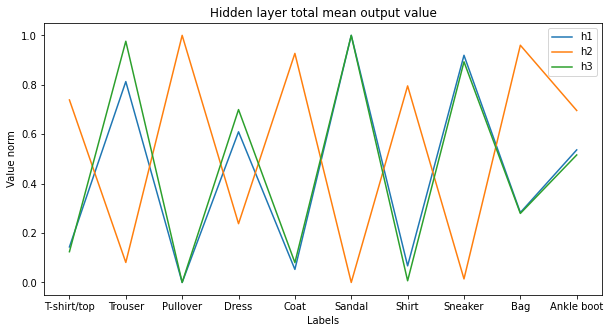

In [56]:
# View the mean activation for each output
def mean_out_hid(mean_hidden_repr_matrix):
  x = np.array([mean_hidden_repr_matrix[x].mean() for x in range(0,10)]).reshape(-1, 1)
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  return min_max_scaler.fit_transform(x)
mean_h1 = mean_out_hid(mean_hidd_repr_matrix_1)
mean_h2 = mean_out_hid(mean_hidd_repr_matrix_2)
mean_h3 = mean_out_hid(mean_hidd_repr_matrix_3)
plt.figure(figsize=(10, 5))
plt.title("Hidden layer total mean output value")
plt.xlabel("Labels")
plt.ylabel("Value norm")
x = list(labels.values())
plt.plot(x, mean_h1, label = "h1")
plt.plot(x, mean_h2, label = "h2")
plt.plot(x, mean_h3, label = "h3")
plt.xticks(x, x)
plt.legend()
plt.show()

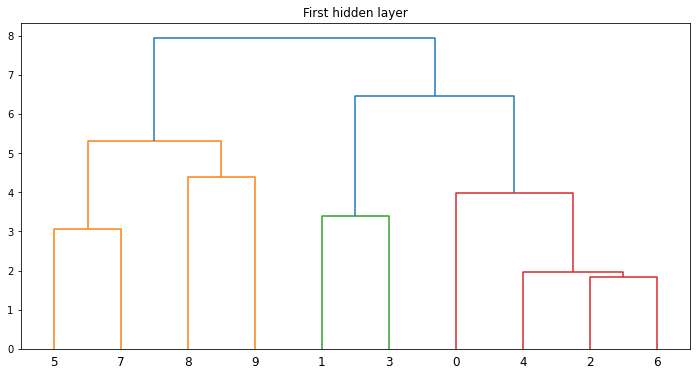

In [57]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

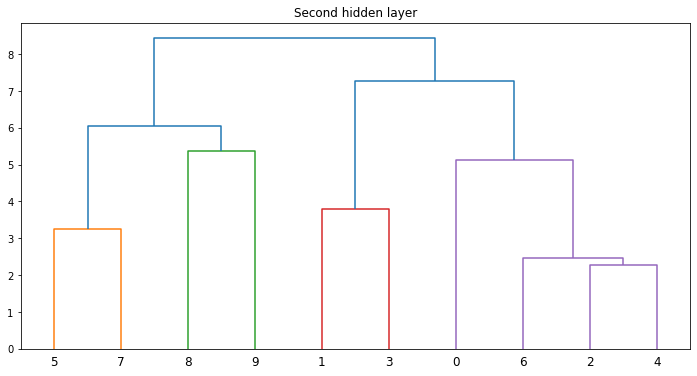

In [58]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

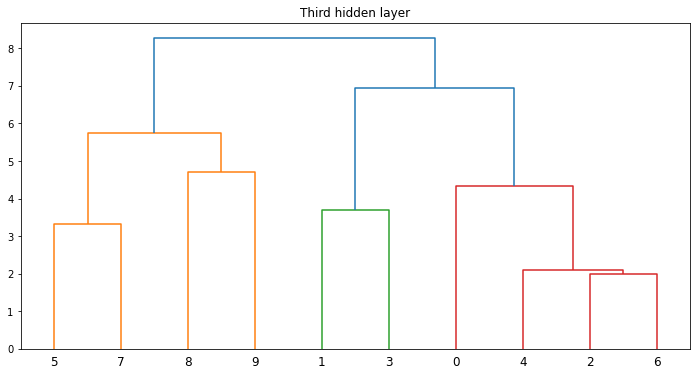

In [59]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

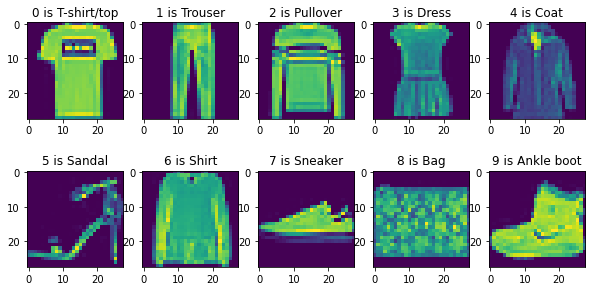

In [60]:
plot_labels()

The visual representations that the network learned is very similar for the first and third hidden layer. 

The DBN is able to cluster similar clothing items together into 3 main clusters: footwear, bottoms (trousers and dresses) and tops, with bags being included in tops.

In the third hidden layer the model learned that the coats, pullovers and shirts are the most similar. T-shirts/tops and bags also fall into the same cluster, while trousers and dresses fall into another. Finally sandals and sneakers are closely clustered under angle boot.

## Robustness to noise

The classification of images after noise implementation has proved a great challenge and the accuracy performance of even state of the art vision models quickly diminishes as the noise levels increase. We will compare the accuracy for different levels of noise injection of a DBN, a FFNN, and a one layer RBM network.

In [61]:
def inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape, device = device)*noise_level #random noise (gaussian)
  return mnist_data + random_gaussian_tensor

Lets see what our images look like when we inject random noise

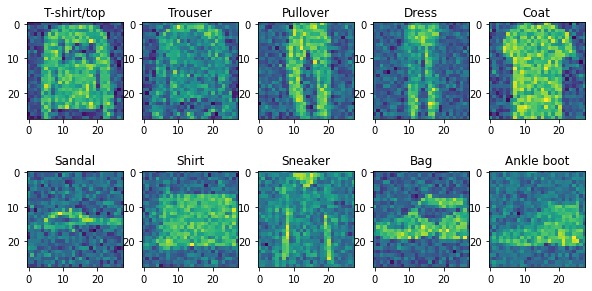

In [62]:
noise_level = 0.2
mnist_test_with_noise = inject_noise(mnist_test.data, noise_level)

# setting values to rows and column variables
rows = 2
columns = 5
fig = plt.figure(figsize=(10, 5))
for i in range(0, 10):
  idx = int(torch.where(mnist_train.targets==i)[0].cpu()[0])
  img = mnist_test_with_noise.data[idx].cpu()
  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, i + 1)
  # showing image
  plt.imshow(img)
  plt.title(f'{labels[i]}')


# for i in range(0, 10):
#   idx = int(torch.where(mnist_train.targets==i)[0].cpu()[0])
#   img = mnist_test_with_noise.data[idx].cpu()
#   print(f'{i} is a {labels[i]}')
#   plt.imshow(img)
#   plt.show()

Compute the accuracy levels for the DBN with noise  injection

In [63]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(mnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, mnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, mnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, mnist_test.targets)
  
  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((10000, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, mnist_test.targets)

  # for the 1 hidden layer network:
  hidden_repr_noisy_1layer = get_kth_layer_repr_1layer(mnist_test_with_noise, 0, device)
  predictions_hidden_noisy_1layer = linear_1layer(hidden_repr_noisy_1layer)
  accuracy_hidden_1layer = compute_accuracy(predictions_hidden_noisy_1layer, mnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn, accuracy_hidden_1layer,
  predictions_first_hidden_noisy, predictions_second_hidden_noisy, predictions_third_hidden_noisy

Psychometric curves for the DBN at different levels of internal representations and the feed-forward neural network:

In [64]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []
  accuracy_values_1layer = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])
    accuracy_values_1layer.append(acc[4])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)
  ax.plot(range(len(noise_levels)), accuracy_values_1layer)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN", "1L network"])

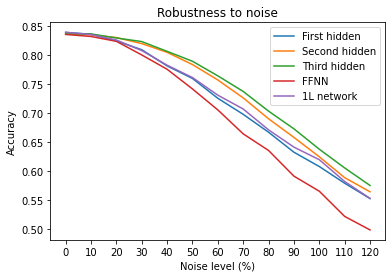

In [65]:
noise_levels = np.arange (0, 1.3, 0.1)
plot_noise_robustness_curves(noise_levels)

The output from the third layer of the DBN is the most robust to noise, this can be a result of the more complex representations learned in the deeper layers of the DBN.

## Adversial attacks

Adversial attacks are a malicious attempt which tries to perturb the original data point into a new data point such that the new data point is misclassified by the classifier. This modification of the original data point is done in such a wat that its imperceptible to the human eye, yet results in the model misclassifying the image. (Chan, 2018)


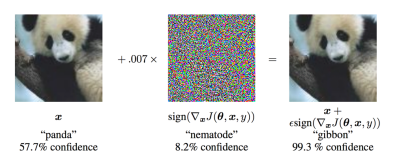

Adversial attack that causes a model to misclassify an image by injecting some noise. (Chan, 2018)

The Fast Gradient Sign method (FGSM) was first developed by Goodfellow et al. in 2014 and is defined as:

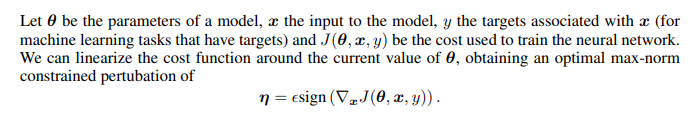

The FGSM adversial attack was found to cause a wide variety of models to misclassify their input. 

"In order to improve the robustness of neural network against the adversarial attack, researchers have proposed a mass of adversarial defense methods, which can be divided into three main categories: modifying data, modifying models and using auxiliary tools." (Qiu et al., 2019)

In [124]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversial samples

In [125]:
#here we create the readout
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [126]:
dbn_with_readout = DBNWithReadOut(dbn_mnist, [linear1, linear2, linear3], readout_level=2)

Lets generate our a redout for our one layer DBN

In [127]:
dbn_with_readout_1layer = DBNWithReadOut(dbn_mnist_1layer, [linear_1layer], readout_level=0) 

Example of an adversial attack:

torch.Size([1, 784])
AxesImage(54,36;334.8x217.44)


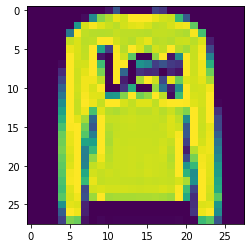

In [128]:
test_sample_idx = 1
test_image = mnist_test.data[test_sample_idx].reshape(1, 784)
print(test_image.shape)
print(plt.imshow(test_image.reshape(28,28).to('cpu')))

In [129]:
attacked_model = ffnn

In [130]:
attacked_model = dbn_with_readout

In [131]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs) #returns the indices of the max value of all elements in the
#input tensor
print(f"The prediction of the model for this clean sample is {labels[int(prediction)]}.")

The prediction of the model for this clean sample is Pullover.


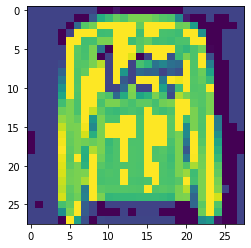

In [132]:
epsilon = 0.2  # define strength of the attack
test_image_label = mnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image, thats why we use mnist_test.targets
#Returns a new tensor with a dimension of size one inserted at the specified position. 
#The returned tensor shares the same underlying data with this tensor.
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [133]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {labels[int(torch.argmax(model_outputs))]}.")

The prediction of the model for the perturbed sample is Bag.


### Resistance to adversial attacks
Comparison between models

In [134]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0
    #!!!!!!!!!!!!!
    # Modified: here we will store our predictions so that we can comopute our confusion
    # matrix
    y_pred = []
    y_true = []
    #!!!!!!!!!!!!!

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)
        

        # Check for success
        # get the index of the max element in the output
        # torch.max Returns the maximum value of all elements in the input tensor.
        final_pred = output.max(1, keepdim=True)[1]
        # torch.argmax Returns the indices of the maximum value of all elements in the input tensor.
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

        #!!!!!!!!!!!!!
        #save our output predictions and labels
        y_pred.extend(final_pred.data.cpu().numpy()) # Save Prediction
        
        labels = target.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        #!!!!!!!!!!!!!

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return [final_acc.item(), y_pred, y_true ]

In [135]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# import pandas as pd

# y_pred = []
# y_true = []

# # iterate over test data
# for inputs, labels in testloader:
#         output = net(inputs) # Feed Network

#         output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#         y_pred.extend(output) # Save Prediction
        
#         labels = labels.data.cpu().numpy()
#         y_true.extend(labels) # Save Truth

In [136]:
# The data loader makes the data manageable as you get batches of the data at a time and
# can iterate through the data set as opposed to loading it all at once
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

FFN

In [137]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 30.89%



Compared to the reat-out trained on the hidden representations of the DBN:

In [138]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 37.44%



And using one step of top-down recontrsutrion from the generative model:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



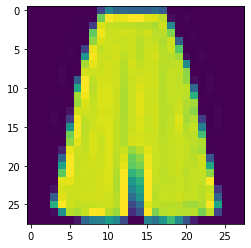


Here's a perturbed sample:



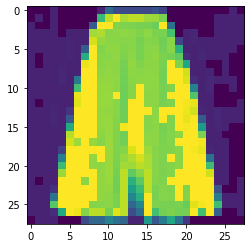


Here's what a 1-steps reconstructed sample looks like:



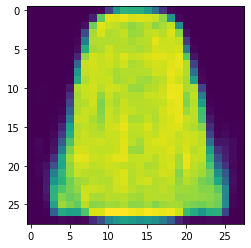


Epsilon: 0.1
Test Accuracy: 35.22%



In [139]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

We compare to a 1 hidden layer network:

In [140]:
final_acc = test_robustness_to_attack(dbn_with_readout_1layer, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 40.80%



### Effect of the noise parameter $\epsilon$

In [141]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()
  predictions = list()
  targets = list()


  for eps in epsilon_values:
      result = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(result[0])
      predictions.append(result[1])
      targets.append(result[2])
  return [accuracies, predictions, targets]

In [142]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)[0]
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)[0]
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)[0]
accuracies_dbn_2 = test_epsilon_values_effect(dbn_with_readout_1layer, n_steps=0)[0]
# accuracies_dbn_3 = test_epsilon_values_effect(dbn_with_readout, n_steps=3)[0]
# accuracies_dbn_4 = test_epsilon_values_effect(dbn_with_readout, n_steps=4)[0]

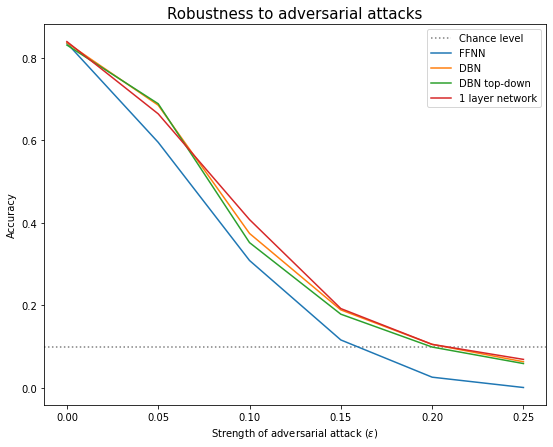

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_dbn_2)
# __ = ax.plot(epsilon_values, accuracies_dbn_3)
# __ = ax.plot(epsilon_values, accuracies_dbn_4)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down", "1 layer network"])

We plot the confusion matrices for each epsilon level of our no step reconstruction DBN:

In [144]:
# We get the predictions as well as the readouts to generate our confusion matrices
# for the dbn with readout
%%capture
dbn_accs_pred_targets_0step = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
dbn_accs_pred_targets_1step = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

In [145]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def plot_cfs(input, noise_lvl_indx):
  # Build confusion matrix
  elem = noise_lvl_indx
  # elem: 1 index is the prediction 2 index is the true (target)
  cf_matrix = confusion_matrix(input[2][elem], input[1][elem])
  # confusion_matrix Returns:
  # Cndarray of shape (n_classes, n_classes)
  # Confusion matrix whose i-th row and j-th column entry indicates the number of samples 
  # with true label being i-th class and predicted label being j-th class.
  # so each row is the truth and each column is the prediction made
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True, fmt='d').set(title=("The epsilon value is " + str(epsilon_values[elem])))
  plt.savefig('output.png')

Confusion matrxi for the DBN with no reconstruction:

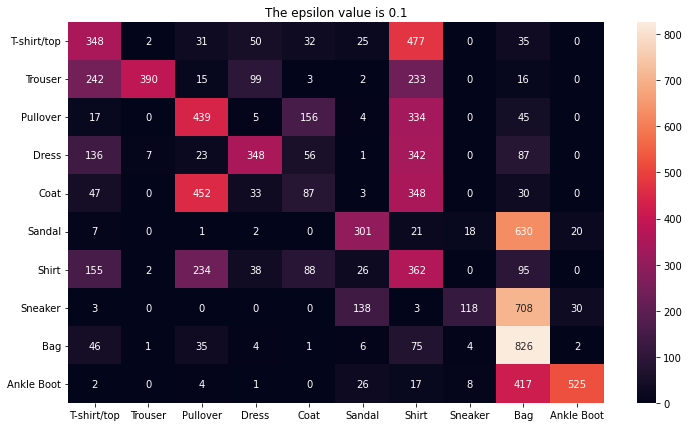

In [146]:
plot_cfs(dbn_accs_pred_targets_0step, 2)

Confusion matrices for the DBN with one step reconstruction:

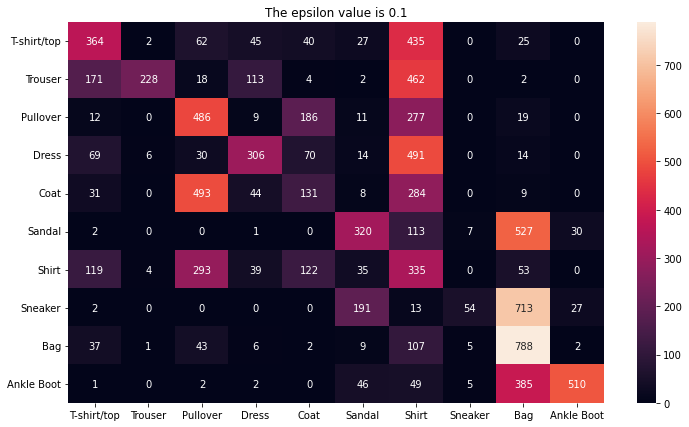

In [147]:
plot_cfs(dbn_accs_pred_targets_1step, 2)

### Results of adversial attacks on the models
The DBN had a significant improvement in performance when classifying attacks that were perturbed through FGSM, at all epsilon values. There appears to be no difference in performance between the one step image reconstruction model and the no step reconstruction. This result contradicts findings of improvement in accuracy through reconstruction in simpler datasets, such as MNIST. 
Through the confusion matrices it can be seen that, when reconstructing images, the model is misclassifying in a greater proportion to the shirt category, implying that the representation of a shirt was strongly learned inside the model and dominating. This causes even sandals to be misclassified as shirts at a much higher percentage after the reconstruction process.

## Few shot learning

Few-shot learning refers to the possibility of learning through a limited number of examples. Humans possess few-shot recognition capabilities, as seen by a child that can recognize images with only one or a few examples, yet many computer vision algorithms rely on a very large number of labeled data and many iterations (epochs) to improve. This can represent important constraints with regards to cost and scalability of the algorithm (Liu et al., 2021). Through the use of unsupervised generative models, that can learn the distribution of unlabeled data, such as a DBN, the necessity to have a large number of labeled data to obtain good results diminishes, as the labeled data is only necessary for the fine tuning of the final classifier.  
Few-shot techniques refer to inputting a limited number of labeled examples into a the learning process of a model. This can range from 0 labeled inputs, also known as zero-shot learning, one input, known as one-shot learning, to a handful of inputs. 

In [81]:
# We obtain the kth layer representation 
# we are specifically interested in the output of our third layer
hidden_repr_layer_1_fs1 = get_kth_layer_repr(mnist_train.data, 0, device)
hidden_repr_layer_2_fs1 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3_fs1 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [114]:
# get our tensors that include the number of samples to train our linear read out
def get_sample_arr(ex_per_clas, hidden_rep):
  """Returns two tensors, the first of data and the second of targets with ex_per_clas
  number of examples per class"""
  mnist_train_data_few = np.empty((0,28,28), float)
  mnist_train_targets_few = np.empty((0), int)
  mnist_hidden_repre_few = np.empty((0, 1000), 'float32')
  indxs = list()
  for a in range(0, ex_per_clas):
    for i in range(0, 10):
      # torch.where returns a tuple of torches where the condition is met
      # we select [0] as we sill only get one torch and then iterate through that one
      idx_1 = int(torch.where(mnist_train.targets==i)[0].cpu()[a]) # index of data that meets condition
      indxs.append(idx_1)
      # we append the data to numpy arrays that we created previously
      mnist_train_data_few = np.append(mnist_train_data_few, [mnist_train.data[idx_1].cpu().numpy()], axis = 0)
      mnist_train_targets_few = np.append(mnist_train_targets_few, [mnist_train.targets[idx_1].cpu().numpy()],axis = 0)
      mnist_hidden_repre_few = np.append(mnist_hidden_repre_few, [hidden_rep[idx_1].cpu().numpy()], axis = 0)
  # return our list of tensors
  return [torch.tensor(mnist_train_data_few).to(device)
          , torch.tensor(mnist_train_targets_few).to(device)
          , torch.tensor(mnist_hidden_repre_few).to(device)
          , indxs]


We will be using 1, 3 and 10  examples, equally distributed among the classes to do the fine tuning of the final output of the model.

In [115]:
# We obtain our subests of data with the number of examples per class that we want
# we also obtain the subset of our hidden representations activations to train 
# our few shot linear read out
#Few shot 1
num_exs_fs1 = 1
mnist_fs1 = get_sample_arr(num_exs_fs1, hidden_repr_layer_3_fs1)
#Few shot 2
num_exs_fs2 = 3
mnist_fs2 = get_sample_arr(num_exs_fs2, hidden_repr_layer_3_fs1)
#Few shot 3
num_exs_fs3 = 10
mnist_fs3 = get_sample_arr(num_exs_fs3, hidden_repr_layer_3_fs1)

In [116]:
# We define our linear classifiers
layer_size = dbn_mnist.rbm_layers[2].W.shape[1]
# Thrid layer few shot linear models:
#Few shot 1
linear3_fs1 = LinearModel(layer_size).to(device)
#Few shot 2
linear3_fs2 = LinearModel(layer_size).to(device)
#Few shot 3
linear3_fs3 = LinearModel(layer_size).to(device)

In [123]:
# Modified verison of  the training function where we input the targets to train on
def train_few_shot(network, input, targets, epochs=1000): # Our input is our hidden representation
  print_stride = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % print_stride == 0:
      print("epoch: {:4d}/{} | loss: {:.3f}".format(epoch, epochs, loss))
  print()

In [118]:
# We train our linear classifier with the amount of data from the few shot learning
#FS 1
train_few_shot(linear3_fs1, mnist_fs1[2], mnist_fs1[1], epochs=1500)
#FS 2
train_few_shot(linear3_fs2, mnist_fs2[2], mnist_fs2[1], epochs=1500)
#FS 3
train_few_shot(linear3_fs3, mnist_fs3[2], mnist_fs3[1], epochs=1500)

epoch:    0/1500 | loss: 2.310
epoch:  100/1500 | loss: 0.105
epoch:  200/1500 | loss: 0.048
epoch:  300/1500 | loss: 0.031
epoch:  400/1500 | loss: 0.023
epoch:  500/1500 | loss: 0.018
epoch:  600/1500 | loss: 0.015
epoch:  700/1500 | loss: 0.013
epoch:  800/1500 | loss: 0.011
epoch:  900/1500 | loss: 0.010
epoch: 1000/1500 | loss: 0.009
epoch: 1100/1500 | loss: 0.008
epoch: 1200/1500 | loss: 0.007
epoch: 1300/1500 | loss: 0.007
epoch: 1400/1500 | loss: 0.006

epoch:    0/1500 | loss: 2.223
epoch:  100/1500 | loss: 0.280
epoch:  200/1500 | loss: 0.141
epoch:  300/1500 | loss: 0.093
epoch:  400/1500 | loss: 0.069
epoch:  500/1500 | loss: 0.055
epoch:  600/1500 | loss: 0.045
epoch:  700/1500 | loss: 0.038
epoch:  800/1500 | loss: 0.033
epoch:  900/1500 | loss: 0.030
epoch: 1000/1500 | loss: 0.026
epoch: 1100/1500 | loss: 0.024
epoch: 1200/1500 | loss: 0.022
epoch: 1300/1500 | loss: 0.020
epoch: 1400/1500 | loss: 0.019

epoch:    0/1500 | loss: 2.296
epoch:  100/1500 | loss: 0.478
epoch:

Now that we have our linear classifier trained via few shot we test the accuracy:

In [122]:
# FS 1
predictions_test3_fs1 = linear3_fs1(hidden_repr_layer_3_test)
# FS 2
predictions_test3_fs2 = linear3_fs2(hidden_repr_layer_3_test)
# FS 3
predictions_test3_fs3 = linear3_fs3(hidden_repr_layer_3_test)

In [121]:
print(f'DBN accuracy with linear classifier trained with {num_exs_fs1} examples is {compute_accuracy(predictions_test3_fs1, mnist_test.targets)}')
print(f'DBN accuracy with linear classifier trained with {num_exs_fs2} examples is {compute_accuracy(predictions_test3_fs2, mnist_test.targets)}')
print(f'DBN accuracy with linear classifier trained with {num_exs_fs3} examples is {compute_accuracy(predictions_test3_fs3, mnist_test.targets)}')

DBN accuracy with linear classifier trained with 1 examples is 0.5241000056266785
DBN accuracy with linear classifier trained with 3 examples is 0.6248999834060669
DBN accuracy with linear classifier trained with 10 examples is 0.7419999837875366


The accuracy of the output of the DBN with the few-shot trained linear classifier managed to obtain a 52% accuracy with only one labeled example per class and increased to 74% with 10 examples per class, which shows us that, through the unsupervised learned internal representation of the model, appropriate fine tuning can be done through the use of a contained amount of labeled data, which can represent several economic and time benefits.

These results also highlight the similarity of using a DBN to simulate how cognitive learning is done in human brains, when few examples visual examples are provided.


## Conclusions

The human brain has the capability of quickly learning image representations with as few as one or zero examples. Researchers seek to better understand how this process is done and to mimic certain aspects of biological neural networks through the implementation of artificial neural networks. DBNs offer a variety of strong points in image representation learning, as well as various similarities with the cognitive process of a human brain. The internal representation of the DBN is learned in a unsupervised way and meaningful image representations are generated increasing with the deepness level. Due to this complex learned internal representation, DBNs are more robust to image classification even with noise, a topic that is of great interest as noise may quickly diminish the accuracy of ANN compared to human vision. Another strong point of DBNs is the generation of reconstructed images by passes through the network. Although the reconstruction of images has shown to improve accuracy with adversial attacks in simpler dataset like MNIST, using FashionMNIST dataset did not provide similar results. Some representations, like the t-shirt, dominate internally and are creating a bias for the reconstruction of the images.
Finally, DBNs may be used in few-shot learning scenarios, mimicking the human cognition process by being able to fine tune the classification of images on top of an already learned structure. 

# References

1. Gurney, K. (2018). An introduction to neural networks. CRC press.
2. Russel, S. J., & Norvig, P. (2022). Artificial Intelligence A Modern Approach. Pearson.
3. Bond-Taylor, S., Leach, A., Long, Y., & Willcocks, C. G. (2021). Deep generative  modelling: A comparative review of VAEs, GANs, normalizing flows, energy-based and autoregressive models. arXiv preprint arXiv:2103.04922. 
4. Bengio, Y., Goodfellow, I., & Courville, A. (2017). Deep learning (Vol. 1). Cambridge, MA, USA: MIT press.
5. Goodfellow, I.J.; Shlens, J.; Szegedy, C. Explaining and harnessing adversarial examples. arXiv 2014, arXiv:1412.6572.
6. Qiu, S., Liu, Q., Zhou, S., & Wu, C. (2019). Review of artificial intelligence adversarial attack and defense technologies. Applied Sciences, 9(5), 909.
7. Testolin, A., Stoianov, I., & Zorzi, M. (2017). Letter perception emerges from unsupervised deep learning and recycling of natural image features. Nature human behaviour, 1(9), 657-664.
8. Hasan, R., & Chu, C. H. H. (2022). Noise in Datasets: What Are the Impacts on Classification Performance?. In ICPRAM (pp. 163-170).
9. Chan, S. (2018 )Chapter 3: Adversial attack. Purdue Engineering. https://engineering.purdue.edu/ChanGroup/ECE595/files/chapter3.pdf
10. Liu, C., Fu, Y., Xu, C., Yang, S., Li, J., Wang, C., & Zhang, L. (2021, May). Learning a few-shot embedding model with contrastive learning. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 35, No. 10, pp. 8635-8643).